In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time
import pandas as pd

import copy
import os
import pickle

import numpy as np
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, DatasetBiome, import_libsvm_sparse
from libact.models import SVM
from libact.query_strategies import RepresentativeSampling, UncertaintySampling, RandomSampling,\
    ActiveLearningByLearning, ContextualBanditsActiveLearning
from libact.labelers import IdealLabeler

import tensorflow as tf
from libact.query_strategies.bandits.algorithms.uniform_sampling import UniformSampling
from libact.query_strategies.bandits.algorithms.linear_full_posterior_sampling import LinearFullPosteriorSampling

In [2]:
'''Training Specific ThompsonSampling Sampler'''

num_actions = 5
context_dim = 14
hparams_linear = tf.contrib.training.HParams(num_actions=num_actions,
                                               context_dim=context_dim,
                                               a0=6,
                                               b0=6,
                                               lambda_prior=0.25,
                                               initial_pulls=num_actions)
algoBiome = LinearFullPosteriorSampling('LinFullPost', hparams_linear)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
'''Loading Data from previous runs'''

cbal = list()
fnames = ['cbalCBiome1','cbalCBiome2','cbalCBiome3']
for name in fnames:
    fname = os.path.join(os.getcwd()+'\\outputs\\'+name+'.txt')
    ifile = open(fname,'rb')
    tp, _ = pickle.load(ifile)
    ifile.close()
    cbal.append(tp)

ctxs = pd.DataFrame()
arms = pd.DataFrame()
rws = pd.DataFrame()
for r in cbal:
    ctxs = ctxs.append(r[['iteration','labeled_entropy','labeled_acc','labeled_f1','labeled_precision',
                        'labeled_recall','testing_acc','testing_f1','testing_precision','testing_recall',
                        'testing_acc_change','testing_f1_change','testing_precision_change','testing_recall_change']])
    arms = arms.append(r[['strategy']])
    rws = rws.append(r[['reward']])

In [4]:
ctxs.iloc[4,:]

iteration                   0.033333
labeled_entropy             1.575259
labeled_acc                 0.288000
labeled_f1                  0.089441
labeled_precision           0.057600
labeled_recall              0.200000
testing_acc                 0.275641
testing_f1                  0.086432
testing_precision           0.055128
testing_recall              0.200000
testing_acc_change          0.000000
testing_f1_change           0.000000
testing_precision_change    0.000000
testing_recall_change       0.000000
Name: 4, dtype: float64

In [5]:
ctxs.shape, arms.shape, rws.shape, np.array(arms.iloc[3]), np.array(rws.iloc[3])

((450, 14), (450, 1), (450, 1), array([3], dtype=object), array([0.27564103]))

In [6]:
for idx, ctx in ctxs[:3].iterrows():
    algoBiome.update(np.array(ctx),int(arms.iloc[idx]), np.array(rws.iloc[idx]))

In [11]:
idx = 25
print(algoBiome.action(np.array(ctxs.iloc[idx,:])), int(arms.iloc[idx]))
# print(ctxs.iloc[idx,:])

3 0


In [2]:
# fname = 'algoCBiome.txt'
# ofile = open(fname, 'wb')
# pickle.dump(algoBiome, ofile)
# ofile.close()

fname = 'algoCBiome.txt'
ifile = open(fname, 'rb')
algoBiome = pickle.load(ifile)
ifile.close()

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time
import pandas as pd

import copy
import os
import pickle

import numpy as np
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, DatasetBiome, import_libsvm_sparse
from libact.models import SVM
from libact.query_strategies import RepresentativeSampling, UncertaintySampling, RandomSampling,\
    ActiveLearningByLearning, ContextualBanditsActiveLearning, MultiBanditsActiveLearning, UniformBanditsActiveLearning
from libact.labelers import IdealLabeler

import tensorflow as tf
from libact.query_strategies.bandits.algorithms.uniform_sampling import UniformSampling
from libact.query_strategies.bandits.algorithms.linear_full_posterior_sampling import LinearFullPosteriorSampling
    
# class NetBiome(nn.Module):
#     def __init__(self):
#         super(NetBiome, self).__init__()
#         self.conv1 = nn.Conv2d(3, 96, kernel_size=10, stride=5)
#         self.conv1_drop = nn.Dropout2d()
#         self.conv2 = nn.Conv2d(96, 64, kernel_size=5, stride=2)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(256, 64)
#         self.fc2 = nn.Linear(64, 5)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv1_drop(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = self.conv2_drop(x)
#         x = F.max_pool2d(x, 2)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = x.view(-1, 256)
#         e1 = F.relu(self.fc1(x))
#         x = F.dropout(e1, training=self.training)
#         x = self.fc2(x)
#         return x, e1

#     def get_embedding_dim(self):
#         return 64

class NetBiome(nn.Module):
    def __init__(self):
        super(NetBiome, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=6, stride=3)
        self.convdropout1 = nn.Dropout2d()
        self.conv2 = nn.Conv2d(96, 64, kernel_size=3, stride=2)
        self.convdropout2 = nn.Dropout2d()
        self.fc1 = nn.Linear(576, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.convdropout1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.convdropout2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 576)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        out = F.log_softmax(x, dim=1)
        
        return out, e1

    def get_embedding_dim(self):
        return 128
    
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x, e1

    def get_embedding_dim(self):
        return 50

def split_train_test_Biome(X_raw, y_raw , test_size, n_labeled, args):
    X, y = X_raw, y_raw
    splt_id = int(len(X) * test_size)
    
    X_train, X_test, y_train, y_test = X[splt_id:], X[:splt_id], y[splt_id:], y[:splt_id]
    shuf_id = np.arange(len(X_train))
    np.random.shuffle(shuf_id)
    X_train = X_train[shuf_id]
    y_train = y_train[shuf_id]

    handler = args['handler']

    trn_ds = handler(X_train, np.concatenate([y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]), args['transform'])
    tst_ds = handler(X_test, y_test, args['transform'])
    fully_labeled_trn_ds = handler(X_train, y_train, args['transform'])

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds

class exprCB(object):
    def __init__(self, trn_ds, tst_ds, lbr, model, qs, nquery, args, reward_fn=None):
        print(time.ctime(time.time()))
        self._args = args
        self._trn_ds = trn_ds
        self._tst_ds = tst_ds
        self._lbr = lbr
        self._model = model
        self._qs = qs
        self._nquery = nquery
        self._T = self._qs.T
        self._handler = args['handler']
        self._reward_fn = reward_fn
        
        self._rd = 0
        self._nclasses = self._qs._nclasses
        self._features = pd.DataFrame(columns=['iteration','query_bincount','query_entropy','labeled_bincount','labeled_entropy',
                                                'query_acc','query_f1','query_precision','query_recall','labeled_acc',
                                                'labeled_f1','labeled_precision','labeled_recall','testing_acc','testing_f1',
                                                'testing_precision', 'testing_recall','testing_acc_change',
                                                'testing_f1_change','testing_precision_change','testing_recall_change','strategy',
                                                'strategy_entropy','reward'])
        
        use_cuda = torch.cuda.is_available()
        self._device = torch.device("cuda" if use_cuda else "cpu")
        self._nepoch = self._args['n_epoch']

#         self._optimizer = optim.SGD(self._model.parameters(), **self._args['optimizer_args'])
        self._optimizer = optim.Adam(self._model.parameters(), lr=1e-4, weight_decay=1e-5)
        self._besttestacc = 0

        self.train()
        testing_acc, testing_f1, testing_precision, testing_recall = self.get_scores(self._tst_ds._X, self._tst_ds._y)

        self._prev_acc_te = testing_acc
        self._prev_f1_te = testing_f1
        self._prev_precision_te = testing_precision
        self._prev_recall_te = testing_recall

    def train(self):
        labeled_entry_Xs, labeled_entry_ys = self._trn_ds.get_labeled_entries()
        labeled_dataset = self._handler(labeled_entry_Xs, labeled_entry_ys, transform=self._args['transform'])

        loader_tr = DataLoader(labeled_dataset,
                            shuffle=True, **self._args['loader_tr_args'])

        for epoch in range(1, self._nepoch):
            self._model.train()
            for batch_idx, (x, y) in enumerate(loader_tr):
                x, y = x.to(self._device), y.long().to(self._device)
                self._optimizer.zero_grad()
                out, e1 = self._model(x)
                loss = F.cross_entropy(out, y)
                loss.backward()
                self._optimizer.step()

    def predict(self):
        # predict labels in test set
        loader_te = DataLoader(self._tst_ds, shuffle=False, **self._args['loader_te_args'])

        self._model.eval()
        P = torch.tensor([], dtype=torch.long)
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader_te):
                x = x.to(self._device)
                out, e1 = self._model(x)

                pred = out.max(1)[1]
                P = torch.cat((P,pred.cpu()))

        return P

    def get_scores(self, xs, lb):
        loader_te = DataLoader(self._handler(xs, lb, transform=self._args['transform']),
                            shuffle=False, **self._args['loader_te_args'])
        
        self._model.eval()
        P = torch.tensor([], dtype=torch.long)
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader_te):
                x = x.to(self._device)
                out, e1 = self._model(x)

                pred = out.max(1)[1]
                P = torch.cat((P,pred.cpu()))
        
        acc = accuracy_score(lb, P)
        f1 = f1_score(lb,P,average='macro')
        precision = precision_score(lb,P,average='macro')
        recall = recall_score(lb,P,average='macro')

        return acc, f1, precision, recall

    def get_features(self, ask_id, lb):
        itr = self._rd/self._T

        # getting entropies
        query_bincount = np.bincount(lb, None, self._nclasses)
        query_entropy = entropy(query_bincount)
        
        labeled_x, labeled_y = self._trn_ds.get_labeled_entries()
        labeled_bincount = np.bincount(labeled_y, None, self._nclasses)
        labeled_entropy = entropy(labeled_bincount)

        # query scores
        query_acc, query_f1, query_precision, query_recall = self.get_scores(self._trn_ds._X[ask_id], lb)

        # labeled scores
        labeled_acc, labeled_f1, labeled_precision, labeled_recall = self.get_scores(labeled_x, labeled_y)
        
        # testing scores
        testing_acc, testing_f1, testing_precision, testing_recall = self.get_scores(self._tst_ds._X, self._tst_ds._y)

        testing_acc_change = testing_acc - self._prev_acc_te
        testing_f1_change = testing_f1 - self._prev_f1_te
        testing_precision_change = testing_precision - self._prev_precision_te
        testing_recall_change = testing_recall - self._prev_recall_te

        self._prev_acc_te = testing_acc
        self._prev_f1_te = testing_f1
        self._prev_precision_te = testing_precision
        self._prev_recall_te = testing_recall

        try:
            strategy_entropy = entropy(self._qs.exp4p_.w)
        except AttributeError:
            strategy_entropy = 0
        
        if self._reward_fn == None:
            reward = self._qs.calc_reward_fn()
        else:
            reward = self._reward_fn(testing_acc, testing_acc_change)
            self._qs.rw = reward
            
        self._features = self._features.append({'iteration': itr, 'query_bincount': query_bincount, 'query_entropy': query_entropy,
                              'labeled_bincount': labeled_bincount, 'labeled_entropy': labeled_entropy, 'query_acc': query_acc,
                              'query_f1': query_f1, 'query_precision': query_precision, 'query_recall': query_recall,
                              'labeled_acc': labeled_acc, 'labeled_f1': labeled_f1, 'labeled_precision': labeled_precision, 
                              'labeled_recall': labeled_recall, 'testing_acc': testing_acc, 'testing_f1': testing_f1,
                              'testing_precision': testing_precision, 'testing_recall': testing_recall,
                              'testing_acc_change': testing_acc_change, 'testing_f1_change': testing_f1_change, 
                              'testing_precision_change': testing_precision_change, 'testing_recall_change': testing_recall_change, 
                              'strategy':self._qs.strat_idx ,'strategy_entropy': strategy_entropy, 'reward': reward
                              }, ignore_index=True)
        return self._features.tail(1)
    

    def run(self, quota):
        # E_out = np.array([])

        for nround in range(quota):
            self._rd += 1
            
            print(time.ctime(time.time()), type(self._qs).__name__, "query round:",self._rd)
            # print(self._qs.W, self._qs.raw_rw)

            ask_id = self._qs.make_query(num=self._nquery)
            lb = self._lbr.label(ask_id)
            self._trn_ds.update(ask_id, lb)

            self.train()
            self._qs.update(ask_id, lb)
            
            self._context = self.get_features(ask_id, lb)
            ctx = np.array(self._context[['iteration','labeled_entropy','labeled_acc','labeled_f1','labeled_precision',
                                'labeled_recall','testing_acc','testing_f1','testing_precision','testing_recall',
                                'testing_acc_change','testing_f1_change','testing_precision_change','testing_recall_change']])
            
            self._qs.update_context(ctx) ######## UPDATE CONTEXT
            print(self._features[['strategy','labeled_acc','testing_acc','reward']].tail(1))
            
            if self._features['testing_acc'].iloc[-1] > self._besttestacc:
                self._bestmodel = copy.deepcopy(self._model)
                self._besttestacc = self._features['testing_acc'].iloc[-1]

        return self._features

In [4]:
test_size = 0.20

n_labeled = 1000      # number of samples that are initially labeled

dataname = 'Biome'

fname = 'C:\\Users\\Wan Jing\\Documents\\CSML Dissertation\\Data Admin\\filteredBiome2.txt'
ifile = open(fname, 'rb')
Biome_X, Biome_y, Biome_dist = pickle.load(ifile)
ifile.close()

args_pool = {'MNIST':
                {'n_epoch': 10, 'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
                'loader_tr_args':{'batch_size': 256, 'num_workers': 1},
                'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
                'optimizer_args':{'lr': 0.01, 'momentum': 0.5},
                'handler': Dataset, 'nclasses': 10},
            'Biome':
                {'n_epoch': 4, 'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]),
                'loader_tr_args':{'batch_size': 256, 'num_workers': 0},
                'loader_te_args':{'batch_size': 1000, 'num_workers': 0},
                'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                'handler': DatasetBiome, 'nclasses': 5}
            }

args = args_pool[dataname]

def custom_rw(te_acc, te_acc_change, hp1 = 0.9):
    '''hp1 < 1'''
#     return (hp1**te_acc) * (hp1**te_acc) + (hp1-hp1**te_acc)*te_acc_change*hp1
    return te_acc*(1+ te_acc_change*hp1)

for r in range(1): # repeat the experiment 20 times
    print("%dth experiment" % (r+1))

    results = []

    trn_ds, tst_ds, y_train, fully_labeled_trn_ds = \
        split_train_test_Biome(Biome_X, Biome_y, test_size, n_labeled, args)
    print("Size of Training Set:", len(trn_ds), "; Size of Testing Set:", len(tst_ds))
    lbr = IdealLabeler(fully_labeled_trn_ds)

    # quota = len(y_train) - n_labeled    # number of samples to query
    nquery = 50
    quota = 150

    if dataname == 'MNIST':
        model_cbal = Net1().to("cuda")
    elif dataname == 'Biome':
        model_cbal = NetBiome().to("cuda")
#     model_us = copy.deepcopy(model_us)
#     model_rs = copy.deepcopy(model_us)
#     model_reps = copy.deepcopy(model_us)
#     model_albl = copy.deepcopy(model_us)
#     model_cbal = copy.deepcopy(model_us)
#     model_mbal = copy.deepcopy(model_us)
#     model_ubal = copy.deepcopy(model_us)
    
#     trn_ds2 = copy.deepcopy(trn_ds)
#     trn_ds3 = copy.deepcopy(trn_ds)
#     trn_ds5 = copy.deepcopy(trn_ds)
#     trn_ds6 = copy.deepcopy(trn_ds)

    # Comparing UncertaintySampling strategy with RandomSampling.
    # model is the base learner, e.g. LogisticRegression, SVM ... etc.
#     qs = UncertaintySampling(trn_ds, args, T=quota, model=model_us, method='entropy')
#     expr1 = expr(trn_ds, tst_ds, lbr, model_us, qs, nquery, args)
#     E_out_1 = expr1.run(quota)

#     qs2 = RandomSampling(trn_ds, args, T=quota, model=model_rs)
#     expr2 = expr(trn_ds, tst_ds, lbr, model_rs, qs2, nquery, args)
#     E_out_2 = expr2.run(quota)
    
#     qs3 = RepresentativeSampling(trn_ds, args, T=quota, model=model_reps)
#     expr3 = expr(trn_ds, tst_ds, lbr, model_reps, qs3, nquery, args)
#     E_out_3 = expr3.run(quota)

#     qs5 = ActiveLearningByLearning(trn_ds, args,
#                 query_strategies=[
#                     RandomSampling(trn_ds, args, T=quota, model=model_albl),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='lc'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='sm'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='entropy'),
#                     RepresentativeSampling(trn_ds, args, T=quota, model=model_albl)
#                 ],
#                 T=quota,
#                 uniform_sampler=False,
#                 model=model_albl,
#                 reward_fn = custom_rw
#             )
#     expr5 = expr(trn_ds, tst_ds, lbr, model_albl, qs5, nquery, args, custom_rw)
#     E_out_5 = expr5.run(quota)

    num_actions = 5
    context_dim = 14
#     hparams_linear = tf.contrib.training.HParams(num_actions=num_actions,
#                                                    context_dim=context_dim,
#                                                    a0=6,
#                                                    b0=6,
#                                                    lambda_prior=0.25,
#                                                    initial_pulls=num_actions)
    algo = algoBiome
    qs6 = ContextualBanditsActiveLearning(trn_ds, args,
                query_strategies=[
                    RandomSampling(trn_ds, args, T=quota, model=model_cbal),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='lc'),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='sm'),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='entropy'),
                    RepresentativeSampling(trn_ds, args, T=quota, model=model_cbal)
                ],
                T=quota,
                uniform_sampler=False,
                model=model_cbal,
                cb_strategy=algo,
                reward_fn = custom_rw
            )
    expr6 = exprCB(trn_ds, tst_ds, lbr, model_cbal, qs6, nquery, args, custom_rw)
    E_out_6 = expr6.run(quota)

#     qs7 = MultiBanditsActiveLearning(trn_ds, args,
#                 query_strategies=[
#                     RandomSampling(trn_ds, args, T=quota, model=model_mbal),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_mbal, method='lc'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_mbal, method='sm'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_mbal, method='entropy'),
#                     RepresentativeSampling(trn_ds, args, T=quota, model=model_mbal)
#                 ],
#                 T=quota,
#                 uniform_sampler=False,
#                 model=model_mbal,
#                 reward_fn = custom_rw
#             )
#     expr7 = expr(trn_ds, tst_ds, lbr, model_mbal, qs7, nquery, args, custom_rw)
#     E_out_7 = expr7.run(quota)

#     qs8 = UniformBanditsActiveLearning(trn_ds, args,
#                 query_strategies=[
#                     RandomSampling(trn_ds, args, T=quota, model=model_ubal),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_ubal, method='lc'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_ubal, method='sm'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_ubal, method='entropy'),
#                     RepresentativeSampling(trn_ds, args, T=quota, model=model_ubal)
#                 ],
#                 T=quota,
#                 uniform_sampler=False,
#                 model=model_ubal,
#                 reward_fn = custom_rw
#             )
#     expr8 = expr(trn_ds, tst_ds, lbr, model_ubal, qs8, nquery, args, custom_rw)
#     E_out_8 = expr8.run(quota)
# print(results)

1th experiment
Size of Training Set: 13104 ; Size of Testing Set: 3276
Mon Aug 31 15:43:26 2020


C:\Users\Wan Jing\.conda\envs\deepCB\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mon Aug 31 15:43:29 2020 ContextualBanditsActiveLearning query round: 1
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

  strategy  labeled_acc  testing_acc    reward
0        3     0.294286     0.275641  0.276323
Mon Aug 31 15:43:38 2020 ContextualBanditsActiveLearning query round: 2
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

  strategy  labeled_acc  testing_acc    reward
1        4     0.287273     0.275641  0.275641
Mon Aug 31 15:43:49 2020 ContextualBanditsActiveLearning query round: 3
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

  strategy  labeled_acc  testing_acc    reward
2        0     0.284348      0.27442  0.274118
Mon Aug 31 15:43:53 2020 ContextualBanditsActiveLearning query round: 4
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

  strategy  labeled_acc  testing_acc    reward
3        1       0.3025     0.272589  0.272139
Mon Aug 31 15:44:02 2020 ContextualBanditsActiveLearning query round: 5
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

  strategy  labeled_acc  testing_acc   reward
4        2       0.2944     0.275946  0.27678
Mon Aug 31 15:44:11 2020 ContextualBanditsActiveLearning query round: 6
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

  strategy  labeled_acc  testing_acc    reward
5        3     0.293846     0.275946  0.275946
Mon Aug 31 15:44:19 2020 ContextualBanditsActiveLearning query round: 7
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

  strategy  labeled_acc  testing_acc    reward
6        4      0.29037     0.277778  0.278236
Mon Aug 31 15:44:31 2020 ContextualBanditsActiveLearning query round: 8
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

  strategy  labeled_acc  testing_acc    reward
7        0     0.288571     0.277473  0.277396
Mon Aug 31 15:44:35 2020 ContextualBanditsActiveLearning query round: 9
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

  strategy  labeled_acc  testing_acc    reward
8        1     0.285517     0.270452  0.268743
Mon Aug 31 15:44:44 2020 ContextualBanditsActiveLearning query round: 10
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

  strategy  labeled_acc  testing_acc    reward
9        2     0.298667     0.277778  0.279609
Mon Aug 31 15:44:53 2020 ContextualBanditsActiveLearning query round: 11
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
10        3     0.285806     0.266178  0.263399
Mon Aug 31 15:45:02 2020 ContextualBanditsActiveLearning query round: 12
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
11        4       0.2825     0.259768  0.258269
Mon Aug 31 15:45:14 2020 ContextualBanditsActiveLearning query round: 13
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
12        0     0.290303     0.268926  0.271142
Mon Aug 31 15:45:19 2020 ContextualBanditsActiveLearning query round: 14
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
13        1         0.27     0.252747  0.249067
Mon Aug 31 15:45:28 2020 ContextualBanditsActiveLearning query round: 15
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
14        2     0.277714     0.260684  0.262546
Mon Aug 31 15:45:38 2020 ContextualBanditsActiveLearning query round: 16
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc  reward
15        3     0.290556     0.284188  0.2902
Mon Aug 31 15:45:47 2020 ContextualBanditsActiveLearning query round: 17
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
16        4     0.287568     0.282662  0.282274
Mon Aug 31 15:45:59 2020 ContextualBanditsActiveLearning query round: 18
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
17        0     0.286842     0.284188  0.284578
Mon Aug 31 15:46:05 2020 ContextualBanditsActiveLearning query round: 19
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
18        1     0.283077     0.281441  0.280745
Mon Aug 31 15:46:14 2020 ContextualBanditsActiveLearning query round: 20
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
19        2       0.2865     0.278694  0.278004
Mon Aug 31 15:46:24 2020 ContextualBanditsActiveLearning query round: 21
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
20        3     0.292195     0.277473  0.277168
Mon Aug 31 15:46:33 2020 ContextualBanditsActiveLearning query round: 22
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
21        4     0.295238     0.287241  0.289766
Mon Aug 31 15:46:46 2020 ContextualBanditsActiveLearning query round: 23
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc   reward
22        4     0.295349     0.284493  0.28379
Mon Aug 31 15:46:59 2020 ContextualBanditsActiveLearning query round: 24
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
23        1     0.283636     0.281746  0.281049
Mon Aug 31 15:47:09 2020 ContextualBanditsActiveLearning query round: 25
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
24        3     0.288444     0.282051  0.282129
Mon Aug 31 15:47:18 2020 ContextualBanditsActiveLearning query round: 26
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc   reward
25        0     0.289565     0.280525  0.28014
Mon Aug 31 15:47:24 2020 ContextualBanditsActiveLearning query round: 27
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
26        1      0.28766     0.285714  0.287049
Mon Aug 31 15:47:34 2020 ContextualBanditsActiveLearning query round: 28
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc   reward
27        2      0.29125     0.288767  0.28956
Mon Aug 31 15:47:44 2020 ContextualBanditsActiveLearning query round: 29
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
28        4     0.298367     0.289377  0.289536
Mon Aug 31 15:47:57 2020 ContextualBanditsActiveLearning query round: 30
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
29        4          0.3      0.29243  0.293233
Mon Aug 31 15:48:10 2020 ContextualBanditsActiveLearning query round: 31
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
30        3     0.300784     0.288156  0.287048
Mon Aug 31 15:48:20 2020 ContextualBanditsActiveLearning query round: 32
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
31        1     0.293077     0.291819  0.292781
Mon Aug 31 15:48:30 2020 ContextualBanditsActiveLearning query round: 33
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc   reward
32        0     0.298113     0.288462  0.28759
Mon Aug 31 15:48:37 2020 ContextualBanditsActiveLearning query round: 34
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
33        1     0.298889     0.296703  0.298904
Mon Aug 31 15:48:47 2020 ContextualBanditsActiveLearning query round: 35
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
34        3     0.312727     0.297924  0.298252
Mon Aug 31 15:48:57 2020 ContextualBanditsActiveLearning query round: 36
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc   reward
35        3     0.311429     0.302198  0.30336
Mon Aug 31 15:49:07 2020 ContextualBanditsActiveLearning query round: 37
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
36        0     0.312982     0.297924  0.296778
Mon Aug 31 15:49:13 2020 ContextualBanditsActiveLearning query round: 38
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
37        2      0.32069     0.302808  0.304139
Mon Aug 31 15:49:24 2020 ContextualBanditsActiveLearning query round: 39
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
38        0     0.329153     0.304335  0.304753
Mon Aug 31 15:49:30 2020 ContextualBanditsActiveLearning query round: 40
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
39        2        0.339     0.308913  0.310186
Mon Aug 31 15:49:41 2020 ContextualBanditsActiveLearning query round: 41
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
40        2     0.341639     0.310745  0.311257
Mon Aug 31 15:49:52 2020 ContextualBanditsActiveLearning query round: 42
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
41        3     0.333226     0.313797  0.314659
Mon Aug 31 15:50:02 2020 ContextualBanditsActiveLearning query round: 43
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
42        4     0.346032     0.311661  0.311061
Mon Aug 31 15:50:16 2020 ContextualBanditsActiveLearning query round: 44
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc   reward
43        4     0.352187     0.319597  0.32188
Mon Aug 31 15:50:30 2020 ContextualBanditsActiveLearning query round: 45
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
44        2     0.361231     0.317155  0.316458
Mon Aug 31 15:50:40 2020 ContextualBanditsActiveLearning query round: 46
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
45        1     0.358788     0.318987  0.319512
Mon Aug 31 15:50:51 2020 ContextualBanditsActiveLearning query round: 47
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
46        0     0.362687     0.328755  0.331645
Mon Aug 31 15:50:58 2020 ContextualBanditsActiveLearning query round: 48
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
47        4     0.362059     0.330281  0.330735
Mon Aug 31 15:51:13 2020 ContextualBanditsActiveLearning query round: 49
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
48        3     0.367246     0.328449  0.327908
Mon Aug 31 15:51:24 2020 ContextualBanditsActiveLearning query round: 50
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
49        3     0.368571     0.335165  0.337191
Mon Aug 31 15:51:35 2020 ContextualBanditsActiveLearning query round: 51
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc   reward
50        4     0.374648     0.337302  0.33795
Mon Aug 31 15:51:48 2020 ContextualBanditsActiveLearning query round: 52
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
51        2     0.377778     0.332112  0.330561
Mon Aug 31 15:52:00 2020 ContextualBanditsActiveLearning query round: 53
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
52        2     0.372055     0.333028  0.333303
Mon Aug 31 15:52:11 2020 ContextualBanditsActiveLearning query round: 54
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
53        1     0.374595     0.332723  0.332631
Mon Aug 31 15:52:22 2020 ContextualBanditsActiveLearning query round: 55
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
54        0     0.375733     0.337607  0.339091
Mon Aug 31 15:52:29 2020 ContextualBanditsActiveLearning query round: 56
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
55        4     0.377368     0.332418  0.330865
Mon Aug 31 15:52:44 2020 ContextualBanditsActiveLearning query round: 57
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
56        2         0.38     0.332112  0.332021
Mon Aug 31 15:52:55 2020 ContextualBanditsActiveLearning query round: 58
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
57        1     0.382051      0.33547  0.336484
Mon Aug 31 15:53:07 2020 ContextualBanditsActiveLearning query round: 59
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
58        3     0.388861     0.338523  0.339453
Mon Aug 31 15:53:18 2020 ContextualBanditsActiveLearning query round: 60
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
59        1        0.385     0.338523  0.338523
Mon Aug 31 15:53:29 2020 ContextualBanditsActiveLearning query round: 61
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
60        0     0.387654     0.340354  0.340915
Mon Aug 31 15:53:38 2020 ContextualBanditsActiveLearning query round: 62
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
61        3     0.386585     0.336691  0.335581
Mon Aug 31 15:53:49 2020 ContextualBanditsActiveLearning query round: 63
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
62        1     0.386747     0.339438  0.340278
Mon Aug 31 15:54:01 2020 ContextualBanditsActiveLearning query round: 64
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
63        4     0.385238     0.337302  0.336653
Mon Aug 31 15:54:15 2020 ContextualBanditsActiveLearning query round: 65
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
64        3     0.392941     0.340659  0.341689
Mon Aug 31 15:54:27 2020 ContextualBanditsActiveLearning query round: 66
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
65        1     0.393721      0.34188  0.342256
Mon Aug 31 15:54:38 2020 ContextualBanditsActiveLearning query round: 67
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc   reward
66        2     0.393103      0.34188  0.34188
Mon Aug 31 15:54:50 2020 ContextualBanditsActiveLearning query round: 68
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
67        1     0.390909     0.345238  0.346281
Mon Aug 31 15:55:02 2020 ContextualBanditsActiveLearning query round: 69
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
68        2     0.396854      0.34768  0.348444
Mon Aug 31 15:55:14 2020 ContextualBanditsActiveLearning query round: 70
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
69        0     0.401556     0.346154  0.345678
Mon Aug 31 15:55:22 2020 ContextualBanditsActiveLearning query round: 71
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
70        2     0.402418     0.351038  0.352581
Mon Aug 31 15:55:34 2020 ContextualBanditsActiveLearning query round: 72
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
71        1        0.405     0.350733  0.350636
Mon Aug 31 15:55:46 2020 ContextualBanditsActiveLearning query round: 73
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
72        3     0.404946      0.34768  0.346725
Mon Aug 31 15:55:58 2020 ContextualBanditsActiveLearning query round: 74
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
73        1      0.40617     0.350122  0.350892
Mon Aug 31 15:56:10 2020 ContextualBanditsActiveLearning query round: 75
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
74        4     0.411158     0.352564  0.353339
Mon Aug 31 15:56:25 2020 ContextualBanditsActiveLearning query round: 76
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
75        1     0.414167     0.352259  0.352162
Mon Aug 31 15:56:37 2020 ContextualBanditsActiveLearning query round: 77
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
76        4     0.424742     0.356532  0.357904
Mon Aug 31 15:56:52 2020 ContextualBanditsActiveLearning query round: 78
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
77        3     0.420816     0.356532  0.356532
Mon Aug 31 15:57:04 2020 ContextualBanditsActiveLearning query round: 79
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
78        2     0.429091     0.358669  0.359359
Mon Aug 31 15:57:16 2020 ContextualBanditsActiveLearning query round: 80
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
79        2       0.4228     0.356532  0.355847
Mon Aug 31 15:57:29 2020 ContextualBanditsActiveLearning query round: 81
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc   reward
80        3     0.427921     0.362637  0.36463
Mon Aug 31 15:57:41 2020 ContextualBanditsActiveLearning query round: 82
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
81        0     0.422745     0.360195  0.359404
Mon Aug 31 15:57:51 2020 ContextualBanditsActiveLearning query round: 83
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc   reward
82        1      0.43068     0.362943  0.36384
Mon Aug 31 15:58:03 2020 ContextualBanditsActiveLearning query round: 84
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
83        1     0.426538     0.362943  0.362943
Mon Aug 31 15:58:16 2020 ContextualBanditsActiveLearning query round: 85
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
84        3     0.430476       0.3663  0.367407
Mon Aug 31 15:58:28 2020 ContextualBanditsActiveLearning query round: 86
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
85        4     0.441509      0.37149  0.373225
Mon Aug 31 15:58:43 2020 ContextualBanditsActiveLearning query round: 87
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
86        0     0.441682       0.3721  0.372305
Mon Aug 31 15:58:53 2020 ContextualBanditsActiveLearning query round: 88
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
87        1     0.440741     0.367827  0.366412
Mon Aug 31 15:59:06 2020 ContextualBanditsActiveLearning query round: 89
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
88        3     0.447339     0.374542  0.376806
Mon Aug 31 15:59:19 2020 ContextualBanditsActiveLearning query round: 90
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
89        0     0.445455     0.377595  0.378632
Mon Aug 31 15:59:29 2020 ContextualBanditsActiveLearning query round: 91
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
90        2     0.448108     0.380342  0.381282
Mon Aug 31 15:59:42 2020 ContextualBanditsActiveLearning query round: 92
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
91        0     0.450179      0.37851  0.377886
Mon Aug 31 15:59:52 2020 ContextualBanditsActiveLearning query round: 93
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
92        3     0.459115     0.381868  0.383022
Mon Aug 31 16:00:05 2020 ContextualBanditsActiveLearning query round: 94
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
93        1     0.457018     0.382784  0.383099
Mon Aug 31 16:00:18 2020 ContextualBanditsActiveLearning query round: 95
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc   reward
94        3     0.457565     0.379426  0.37828
Mon Aug 31 16:00:31 2020 ContextualBanditsActiveLearning query round: 96
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
95        0     0.460862      0.38431  0.385999
Mon Aug 31 16:00:42 2020 ContextualBanditsActiveLearning query round: 97
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
96        2     0.460513     0.384921  0.385132
Mon Aug 31 16:00:55 2020 ContextualBanditsActiveLearning query round: 98
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

   strategy  labeled_acc  testing_acc    reward
97        4     0.462203     0.383089  0.382458
Mon Aug 31 16:01:10 2020 ContextualBanditsActiveLearning query round: 99
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
98        1     0.470084     0.387973  0.389679
Mon Aug 31 16:01:23 2020 ContextualBanditsActiveLearning query round: 100
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

   strategy  labeled_acc  testing_acc    reward
99        0     0.476667     0.385531  0.384684
Mon Aug 31 16:01:34 2020 ContextualBanditsActiveLearning query round: 101
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
100        0     0.475537     0.388278  0.389238
Mon Aug 31 16:01:45 2020 ContextualBanditsActiveLearning query round: 102
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

    strategy  labeled_acc  testing_acc    reward
101        4     0.468689     0.384921  0.383757
Mon Aug 31 16:02:00 2020 ContextualBanditsActiveLearning query round: 103
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
102        3     0.472683     0.380952  0.379592
Mon Aug 31 16:02:14 2020 ContextualBanditsActiveLearning query round: 104
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
103        1     0.485806     0.392247  0.396234
Mon Aug 31 16:02:28 2020 ContextualBanditsActiveLearning query round: 105
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
104        0      0.48192     0.391026  0.390596
Mon Aug 31 16:02:39 2020 ContextualBanditsActiveLearning query round: 106
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
105        1     0.488254     0.391026  0.391026
Mon Aug 31 16:02:52 2020 ContextualBanditsActiveLearning query round: 107
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
106        3     0.488031     0.394078  0.395161
Mon Aug 31 16:03:06 2020 ContextualBanditsActiveLearning query round: 108
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
107        2     0.482969     0.388889  0.387073
Mon Aug 31 16:03:20 2020 ContextualBanditsActiveLearning query round: 109
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
108        3     0.488837     0.392247  0.393432
Mon Aug 31 16:03:34 2020 ContextualBanditsActiveLearning query round: 110
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
109        3        0.492     0.396825  0.398461
Mon Aug 31 16:03:47 2020 ContextualBanditsActiveLearning query round: 111
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

    strategy  labeled_acc  testing_acc    reward
110        4     0.490382     0.398046  0.398484
Mon Aug 31 16:04:03 2020 ContextualBanditsActiveLearning query round: 112
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

    strategy  labeled_acc  testing_acc    reward
111        4     0.493485     0.394078  0.392671
Mon Aug 31 16:04:19 2020 ContextualBanditsActiveLearning query round: 113
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc  reward
112        1     0.501654     0.398657  0.4003
Mon Aug 31 16:04:33 2020 ContextualBanditsActiveLearning query round: 114
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

    strategy  labeled_acc  testing_acc    reward
113        4     0.501642     0.392247  0.389984
Mon Aug 31 16:04:49 2020 ContextualBanditsActiveLearning query round: 115
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc  reward
114        3     0.504296     0.395604  0.3968
Mon Aug 31 16:05:03 2020 ContextualBanditsActiveLearning query round: 116
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
115        1     0.515441     0.398962  0.400168
Mon Aug 31 16:05:17 2020 ContextualBanditsActiveLearning query round: 117
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
116        2     0.509197     0.398962  0.398962
Mon Aug 31 16:05:32 2020 ContextualBanditsActiveLearning query round: 118
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

    strategy  labeled_acc  testing_acc   reward
117        4     0.518986     0.397436  0.39689
Mon Aug 31 16:05:48 2020 ContextualBanditsActiveLearning query round: 119
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
118        2     0.510072     0.403846  0.406176
Mon Aug 31 16:06:02 2020 ContextualBanditsActiveLearning query round: 120
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
119        1     0.521429     0.403236  0.403014
Mon Aug 31 16:06:17 2020 ContextualBanditsActiveLearning query round: 121
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
120        2     0.526383     0.397741  0.395774
Mon Aug 31 16:06:31 2020 ContextualBanditsActiveLearning query round: 122
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc   reward
121        2     0.524366     0.392857  0.39113
Mon Aug 31 16:06:46 2020 ContextualBanditsActiveLearning query round: 123
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc   reward
122        0     0.525035     0.404151  0.40826
Mon Aug 31 16:06:58 2020 ContextualBanditsActiveLearning query round: 124
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
123        2     0.534167      0.40293  0.402488
Mon Aug 31 16:07:12 2020 ContextualBanditsActiveLearning query round: 125
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
124        1      0.53531     0.401709  0.401268
Mon Aug 31 16:07:27 2020 ContextualBanditsActiveLearning query round: 126
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

    strategy  labeled_acc  testing_acc    reward
125        4     0.536849     0.407814  0.410055
Mon Aug 31 16:07:43 2020 ContextualBanditsActiveLearning query round: 127
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
126        2     0.548163     0.411172  0.412415
Mon Aug 31 16:07:58 2020 ContextualBanditsActiveLearning query round: 128
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
127        1     0.534459     0.407814  0.406582
Mon Aug 31 16:08:13 2020 ContextualBanditsActiveLearning query round: 129
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
128        3     0.537584     0.409341  0.409903
Mon Aug 31 16:08:27 2020 ContextualBanditsActiveLearning query round: 130
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
129        0     0.549733     0.403846  0.401849
Mon Aug 31 16:08:40 2020 ContextualBanditsActiveLearning query round: 131
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
130        0     0.551523     0.411477  0.414303
Mon Aug 31 16:08:53 2020 ContextualBanditsActiveLearning query round: 132
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
131        0     0.557368     0.410256  0.409806
Mon Aug 31 16:09:06 2020 ContextualBanditsActiveLearning query round: 133
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
132        3     0.552288     0.405983  0.404421
Mon Aug 31 16:09:21 2020 ContextualBanditsActiveLearning query round: 134
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
133        0     0.556234     0.407509  0.408069
Mon Aug 31 16:09:34 2020 ContextualBanditsActiveLearning query round: 135
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
134        2     0.561548     0.411783  0.413366
Mon Aug 31 16:09:49 2020 ContextualBanditsActiveLearning query round: 136
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
135        3     0.568718     0.410256  0.409693
Mon Aug 31 16:10:04 2020 ContextualBanditsActiveLearning query round: 137
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
136        2     0.564968     0.411783  0.412348
Mon Aug 31 16:10:19 2020 ContextualBanditsActiveLearning query round: 138
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
137        3     0.554557     0.410256  0.409693
Mon Aug 31 16:10:35 2020 ContextualBanditsActiveLearning query round: 139
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
138        1     0.580881     0.414225  0.415704
Mon Aug 31 16:10:50 2020 ContextualBanditsActiveLearning query round: 140
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc   reward
139        0     0.573125     0.413004  0.41255
Mon Aug 31 16:11:03 2020 ContextualBanditsActiveLearning query round: 141
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
140        1     0.586335     0.411477  0.410912
Mon Aug 31 16:11:19 2020 ContextualBanditsActiveLearning query round: 142
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
141        2     0.591235     0.413919  0.414829
Mon Aug 31 16:11:35 2020 ContextualBanditsActiveLearning query round: 143
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
142        1     0.589939     0.411172  0.410156
Mon Aug 31 16:11:51 2020 ContextualBanditsActiveLearning query round: 144
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
143        1     0.586829      0.41514  0.416623
Mon Aug 31 16:12:06 2020 ContextualBanditsActiveLearning query round: 145
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

    strategy  labeled_acc  testing_acc    reward
144        4     0.591273     0.411783  0.410538
Mon Aug 31 16:12:23 2020 ContextualBanditsActiveLearning query round: 146
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

    strategy  labeled_acc  testing_acc    reward
145        4     0.600602     0.412698  0.413039
Mon Aug 31 16:12:40 2020 ContextualBanditsActiveLearning query round: 147
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
146        2     0.597605     0.411783  0.411443
Mon Aug 31 16:12:56 2020 ContextualBanditsActiveLearning query round: 148
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
147        3     0.607619     0.410867  0.410528
Mon Aug 31 16:13:11 2020 ContextualBanditsActiveLearning query round: 149
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc   reward
148        2     0.600828     0.412393  0.41296
Mon Aug 31 16:13:27 2020 ContextualBanditsActiveLearning query round: 150
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

    strategy  labeled_acc  testing_acc    reward
149        1     0.598824     0.405372  0.402811


0.41514041514041516


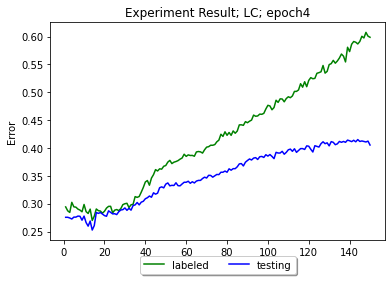

In [5]:
import matplotlib.pyplot as plt

print(expr6._besttestacc)

query_num = range(1,150+1)
plt.plot(query_num, E_out_6['labeled_acc'], 'g', label='labeled')
plt.plot(query_num, E_out_6['testing_acc'], 'b', label='testing')

plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('Experiment Result; LC; epoch4')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=5)
plt.show()

In [6]:
fname = 'cbalCTBiome3.txt'
ofile = open(fname, 'wb')
pickle.dump([E_out_6, 'epoch=4; quota=150'], ofile)
ofile.close()

# IW-Acc reward

In [3]:
class NetBiome(nn.Module):
    def __init__(self):
        super(NetBiome, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=6, stride=3)
        self.convdropout1 = nn.Dropout2d()
        self.conv2 = nn.Conv2d(96, 64, kernel_size=3, stride=2)
        self.convdropout2 = nn.Dropout2d()
        self.fc1 = nn.Linear(576, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.convdropout1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.convdropout2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 576)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        out = F.log_softmax(x, dim=1)
        
        return out, e1

    def get_embedding_dim(self):
        return 128
    
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        e1 = F.relu(self.fc1(x))
        x = F.dropout(e1, training=self.training)
        x = self.fc2(x)
        return x, e1

    def get_embedding_dim(self):
        return 50

def split_train_test_Biome(X_raw, y_raw , test_size, n_labeled, args):
    X, y = X_raw, y_raw
    splt_id = int(len(X) * test_size)
    
    X_train, X_test, y_train, y_test = X[splt_id:], X[:splt_id], y[splt_id:], y[:splt_id]
    shuf_id = np.arange(len(X_train))
    np.random.shuffle(shuf_id)
    X_train = X_train[shuf_id]
    y_train = y_train[shuf_id]

    handler = args['handler']

    trn_ds = handler(X_train, np.concatenate([y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]), args['transform'])
    tst_ds = handler(X_test, y_test, args['transform'])
    fully_labeled_trn_ds = handler(X_train, y_train, args['transform'])

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds

class exprCB(object):
    def __init__(self, trn_ds, tst_ds, lbr, model, qs, nquery, args):
        print(time.ctime(time.time()))
        self._args = args
        self._trn_ds = trn_ds
        self._tst_ds = tst_ds
        self._lbr = lbr
        self._model = model
        self._qs = qs
        self._nquery = nquery
        self._T = self._qs.T
        self._handler = args['handler']
        
        self._rd = 0
        self._nclasses = self._qs._nclasses
        self._features = pd.DataFrame(columns=['iteration','query_bincount','query_entropy','labeled_bincount','labeled_entropy',
                                                'query_acc','query_f1','query_precision','query_recall','labeled_acc',
                                                'labeled_f1','labeled_precision','labeled_recall','testing_acc','testing_f1',
                                                'testing_precision', 'testing_recall','testing_acc_change',
                                                'testing_f1_change','testing_precision_change','testing_recall_change','strategy',
                                                'strategy_entropy','reward'])
        
        use_cuda = torch.cuda.is_available()
        self._device = torch.device("cuda" if use_cuda else "cpu")
        self._nepoch = self._args['n_epoch']

#         self._optimizer = optim.SGD(self._model.parameters(), **self._args['optimizer_args'])
        self._optimizer = optim.Adam(self._model.parameters(), lr=1e-4, weight_decay=1e-5)
        self._besttestacc = 0

        self.train()
        testing_acc, testing_f1, testing_precision, testing_recall = self.get_scores(self._tst_ds._X, self._tst_ds._y)

        self._prev_acc_te = testing_acc
        self._prev_f1_te = testing_f1
        self._prev_precision_te = testing_precision
        self._prev_recall_te = testing_recall

    def train(self):
        labeled_entry_Xs, labeled_entry_ys = self._trn_ds.get_labeled_entries()
        labeled_dataset = self._handler(labeled_entry_Xs, labeled_entry_ys, transform=self._args['transform'])

        loader_tr = DataLoader(labeled_dataset,
                            shuffle=True, **self._args['loader_tr_args'])

        for epoch in range(1, self._nepoch):
            self._model.train()
            for batch_idx, (x, y) in enumerate(loader_tr):
                x, y = x.to(self._device), y.long().to(self._device)
                self._optimizer.zero_grad()
                out, e1 = self._model(x)
                loss = F.cross_entropy(out, y)
                loss.backward()
                self._optimizer.step()

    def predict(self):
        # predict labels in test set
        loader_te = DataLoader(self._tst_ds, shuffle=False, **self._args['loader_te_args'])

        self._model.eval()
        P = torch.tensor([], dtype=torch.long)
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader_te):
                x = x.to(self._device)
                out, e1 = self._model(x)

                pred = out.max(1)[1]
                P = torch.cat((P,pred.cpu()))

        return P

    def get_scores(self, xs, lb):
        loader_te = DataLoader(self._handler(xs, lb, transform=self._args['transform']),
                            shuffle=False, **self._args['loader_te_args'])
        
        self._model.eval()
        P = torch.tensor([], dtype=torch.long)
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader_te):
                x = x.to(self._device)
                out, e1 = self._model(x)

                pred = out.max(1)[1]
                P = torch.cat((P,pred.cpu()))
        
        acc = accuracy_score(lb, P)
        f1 = f1_score(lb,P,average='macro')
        precision = precision_score(lb,P,average='macro')
        recall = recall_score(lb,P,average='macro')

        return acc, f1, precision, recall

    def get_features(self, ask_id, lb):
        itr = self._rd/self._T

        # getting entropies
        query_bincount = np.bincount(lb, None, self._nclasses)
        query_entropy = entropy(query_bincount)
        
        labeled_x, labeled_y = self._trn_ds.get_labeled_entries()
        labeled_bincount = np.bincount(labeled_y, None, self._nclasses)
        labeled_entropy = entropy(labeled_bincount)

        # query scores
        query_acc, query_f1, query_precision, query_recall = self.get_scores(self._trn_ds._X[ask_id], lb)

        # labeled scores
        labeled_acc, labeled_f1, labeled_precision, labeled_recall = self.get_scores(labeled_x, labeled_y)
        
        # testing scores
        testing_acc, testing_f1, testing_precision, testing_recall = self.get_scores(self._tst_ds._X, self._tst_ds._y)

        testing_acc_change = testing_acc - self._prev_acc_te
        testing_f1_change = testing_f1 - self._prev_f1_te
        testing_precision_change = testing_precision - self._prev_precision_te
        testing_recall_change = testing_recall - self._prev_recall_te

        self._prev_acc_te = testing_acc
        self._prev_f1_te = testing_f1
        self._prev_precision_te = testing_precision
        self._prev_recall_te = testing_recall

        try:
            strategy_entropy = entropy(self._qs.exp4p_.w)
        except AttributeError:
            strategy_entropy = 0

        reward = self._qs.calc_reward_fn()
        self._features = self._features.append({'iteration': itr, 'query_bincount': query_bincount, 'query_entropy': query_entropy,
                              'labeled_bincount': labeled_bincount, 'labeled_entropy': labeled_entropy, 'query_acc': query_acc,
                              'query_f1': query_f1, 'query_precision': query_precision, 'query_recall': query_recall,
                              'labeled_acc': labeled_acc, 'labeled_f1': labeled_f1, 'labeled_precision': labeled_precision, 
                              'labeled_recall': labeled_recall, 'testing_acc': testing_acc, 'testing_f1': testing_f1,
                              'testing_precision': testing_precision, 'testing_recall': testing_recall,
                              'testing_acc_change': testing_acc_change, 'testing_f1_change': testing_f1_change, 
                              'testing_precision_change': testing_precision_change, 'testing_recall_change': testing_recall_change, 
                              'strategy':self._qs.strat_idx ,'strategy_entropy': strategy_entropy, 'reward': reward
                              }, ignore_index=True)
        return self._features.tail(1)
    

    def run(self, quota):
        # E_out = np.array([])

        for nround in range(quota):
            self._rd += 1
            
            print(time.ctime(time.time()), type(self._qs).__name__, "query round:",self._rd)
            # print(self._qs.W, self._qs.raw_rw)

            ask_id = self._qs.make_query(num=self._nquery)
            lb = self._lbr.label(ask_id)
            self._trn_ds.update(ask_id, lb)

            self.train()
            self._qs.update(ask_id, lb)
            
            self._context = self.get_features(ask_id, lb)
            ctx = np.array(self._context[['iteration','labeled_entropy','labeled_acc','labeled_f1','labeled_precision',
                                'labeled_recall','testing_acc','testing_f1','testing_precision','testing_recall',
                                'testing_acc_change','testing_f1_change','testing_precision_change','testing_recall_change']])

            self._qs.update_context(ctx) ######## UPDATE CONTEXT
            print(self._features[['strategy','labeled_acc','testing_acc']].tail(1))
            
            if self._features['testing_acc'].iloc[-1] > self._besttestacc:
                self._bestmodel = copy.deepcopy(self._model)
                self._besttestacc = self._features['testing_acc'].iloc[-1]

        return self._features

In [4]:
test_size = 0.20

n_labeled = 1000      # number of samples that are initially labeled

dataname = 'Biome'

fname = 'C:\\Users\\Wan Jing\\Documents\\CSML Dissertation\\Data Admin\\filteredBiome2.txt'
ifile = open(fname, 'rb')
Biome_X, Biome_y, Biome_dist = pickle.load(ifile)
ifile.close()

args_pool = {'MNIST':
                {'n_epoch': 10, 'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
                'loader_tr_args':{'batch_size': 256, 'num_workers': 1},
                'loader_te_args':{'batch_size': 1000, 'num_workers': 1},
                'optimizer_args':{'lr': 0.01, 'momentum': 0.5},
                'handler': Dataset, 'nclasses': 10},
            'Biome':
                {'n_epoch': 4, 'transform': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]),
                'loader_tr_args':{'batch_size': 256, 'num_workers': 0},
                'loader_te_args':{'batch_size': 1000, 'num_workers': 0},
                'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                'handler': DatasetBiome, 'nclasses': 5}
            }

args = args_pool[dataname]

for r in range(1): # repeat the experiment 20 times
    print("%dth experiment" % (r+1))

    results = []

    trn_ds, tst_ds, y_train, fully_labeled_trn_ds = \
        split_train_test_Biome(Biome_X, Biome_y, test_size, n_labeled, args)
    print("Size of Training Set:", len(trn_ds), "; Size of Testing Set:", len(tst_ds))
    lbr = IdealLabeler(fully_labeled_trn_ds)

    # quota = len(y_train) - n_labeled    # number of samples to query
    nquery = 50
    quota = 150

    if dataname == 'MNIST':
        model_cbal = Net1().to("cuda")
    elif dataname == 'Biome':
        model_cbal = NetBiome().to("cuda")
#     model_us = copy.deepcopy(model_us)
#     model_rs = copy.deepcopy(model_us)
#     model_reps = copy.deepcopy(model_us)
#     model_albl = copy.deepcopy(model_us)
#     model_cbal = copy.deepcopy(model_us)
    
#     trn_ds2 = copy.deepcopy(trn_ds)
#     trn_ds3 = copy.deepcopy(trn_ds)
#     trn_ds5 = copy.deepcopy(trn_ds)
#     trn_ds6 = copy.deepcopy(trn_ds)

    # Comparing UncertaintySampling strategy with RandomSampling.
    # model is the base learner, e.g. LogisticRegression, SVM ... etc.
#     qs = UncertaintySampling(trn_ds, args, T=quota, model=model_us, method='entropy')
#     expr1 = expr(trn_ds, tst_ds, lbr, model_us, qs, nquery, args)
#     E_out_1 = expr1.run(quota)

#     qs2 = RandomSampling(trn_ds, args, T=quota, model=model_rs)
#     expr2 = expr(trn_ds, tst_ds, lbr, model_rs, qs2, nquery, args)
#     E_out_2 = expr2.run(quota)
    
#     qs3 = RepresentativeSampling(trn_ds, args, T=quota, model=model_reps)
#     expr3 = expr(trn_ds, tst_ds, lbr, model_reps, qs3, nquery, args)
#     E_out_3 = expr3.run(quota)

#     qs5 = ActiveLearningByLearning(trn_ds, args,
#                 query_strategies=[
#                     RandomSampling(trn_ds, args, T=quota, model=model_albl),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='lc'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='sm'),
#                     UncertaintySampling(trn_ds, args, T=quota, model=model_albl, method='entropy'),
#                     RepresentativeSampling(trn_ds, args, T=quota, model=model_albl)
#                 ],
#                 T=quota,
#                 uniform_sampler=False,
#                 model=model_albl
#             )
#     expr5 = expr(trn_ds, tst_ds, lbr, model_albl, qs5, nquery, args)
#     E_out_5 = expr5.run(quota)

    num_actions = 5
    context_dim = 14
#     hparams_linear = tf.contrib.training.HParams(num_actions=num_actions,
#                                                    context_dim=context_dim,
#                                                    a0=6,
#                                                    b0=6,
#                                                    lambda_prior=0.25,
#                                                    initial_pulls=num_actions)
    algo = algoBiome
    qs6 = ContextualBanditsActiveLearning(trn_ds, args,
                query_strategies=[
                    RandomSampling(trn_ds, args, T=quota, model=model_cbal),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='lc'),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='sm'),
                    UncertaintySampling(trn_ds, args, T=quota, model=model_cbal, method='entropy'),
                    RepresentativeSampling(trn_ds, args, T=quota, model=model_cbal)
                ],
                T=quota,
                uniform_sampler=False,
                model=model_cbal,
                cb_strategy=algo
            )
    expr6 = exprCB(trn_ds, tst_ds, lbr, model_cbal, qs6, nquery, args)
    E_out_6 = expr6.run(quota)
    
# print(results)

1th experiment
Size of Training Set: 13104 ; Size of Testing Set: 3276
Tue Aug 25 05:47:20 2020


C:\Users\Wan Jing\.conda\envs\deepCB\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tue Aug 25 05:47:23 2020 ContextualBanditsActiveLearning query round: 1
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

  strategy  labeled_acc  testing_acc
0        3     0.305714     0.275641
Tue Aug 25 05:47:32 2020 ContextualBanditsActiveLearning query round: 2
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  strategy  labeled_acc  testing_acc
1        4     0.301818     0.275641
Tue Aug 25 05:47:44 2020 ContextualBanditsActiveLearning query round: 3
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

  strategy  labeled_acc  testing_acc
2        0     0.302609     0.275641
Tue Aug 25 05:47:48 2020 ContextualBanditsActiveLearning query round: 4
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

  strategy  labeled_acc  testing_acc
3        1     0.298333     0.275641
Tue Aug 25 05:47:57 2020 ContextualBanditsActiveLearning query round: 5
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

  strategy  labeled_acc  testing_acc
4        2       0.2968     0.275641
Tue Aug 25 05:48:06 2020 ContextualBanditsActiveLearning query round: 6
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

  strategy  labeled_acc  testing_acc
5        3     0.290769     0.275641
Tue Aug 25 05:48:15 2020 ContextualBanditsActiveLearning query round: 7
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  strategy  labeled_acc  testing_acc
6        4     0.285926     0.275641
Tue Aug 25 05:48:28 2020 ContextualBanditsActiveLearning query round: 8
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

  strategy  labeled_acc  testing_acc
7        0     0.286429     0.275641
Tue Aug 25 05:48:32 2020 ContextualBanditsActiveLearning query round: 9
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

  strategy  labeled_acc  testing_acc
8        1     0.283448     0.275641
Tue Aug 25 05:48:41 2020 ContextualBanditsActiveLearning query round: 10
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

  strategy  labeled_acc  testing_acc
9        2     0.283333     0.275641
Tue Aug 25 05:48:50 2020 ContextualBanditsActiveLearning query round: 11
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
10        3     0.284516     0.275641
Tue Aug 25 05:49:00 2020 ContextualBanditsActiveLearning query round: 12
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
11        4     0.283125     0.275641
Tue Aug 25 05:49:12 2020 ContextualBanditsActiveLearning query round: 13
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
12        0     0.283636     0.275641
Tue Aug 25 05:49:17 2020 ContextualBanditsActiveLearning query round: 14
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
13        1     0.280588     0.275641
Tue Aug 25 05:49:26 2020 ContextualBanditsActiveLearning query round: 15
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
14        2     0.278286     0.275641
Tue Aug 25 05:49:36 2020 ContextualBanditsActiveLearning query round: 16
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
15        3     0.276111     0.275641
Tue Aug 25 05:49:45 2020 ContextualBanditsActiveLearning query round: 17
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
16        4     0.278378     0.275641
Tue Aug 25 05:49:57 2020 ContextualBanditsActiveLearning query round: 18
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
17        0     0.279474     0.275641
Tue Aug 25 05:50:03 2020 ContextualBanditsActiveLearning query round: 19
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
18        1     0.278974     0.275641
Tue Aug 25 05:50:12 2020 ContextualBanditsActiveLearning query round: 20
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
19        2       0.2785      0.27381
Tue Aug 25 05:50:22 2020 ContextualBanditsActiveLearning query round: 21
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
20        3     0.276585     0.275336
Tue Aug 25 05:50:32 2020 ContextualBanditsActiveLearning query round: 22
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
21        4      0.27381     0.275031
Tue Aug 25 05:50:45 2020 ContextualBanditsActiveLearning query round: 23
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
22        4     0.275349     0.275946
Tue Aug 25 05:50:58 2020 ContextualBanditsActiveLearning query round: 24
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
23        0     0.272273     0.275641
Tue Aug 25 05:51:03 2020 ContextualBanditsActiveLearning query round: 25
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
24        0     0.290222     0.276557
Tue Aug 25 05:51:09 2020 ContextualBanditsActiveLearning query round: 26
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
25        0     0.293043     0.278999
Tue Aug 25 05:51:15 2020 ContextualBanditsActiveLearning query round: 27
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
26        2     0.290213      0.28022
Tue Aug 25 05:51:25 2020 ContextualBanditsActiveLearning query round: 28
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
27        3     0.299583     0.280525
Tue Aug 25 05:51:35 2020 ContextualBanditsActiveLearning query round: 29
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
28        2     0.304898     0.278388
Tue Aug 25 05:51:46 2020 ContextualBanditsActiveLearning query round: 30
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
29        3       0.3044      0.27442
Tue Aug 25 05:51:56 2020 ContextualBanditsActiveLearning query round: 31
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
30        4     0.307843     0.278694
Tue Aug 25 05:52:10 2020 ContextualBanditsActiveLearning query round: 32
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
31        2     0.298077     0.276862
Tue Aug 25 05:52:20 2020 ContextualBanditsActiveLearning query round: 33
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
32        0     0.302642     0.285104
Tue Aug 25 05:52:26 2020 ContextualBanditsActiveLearning query round: 34
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
33        0     0.312222      0.29304
Tue Aug 25 05:52:33 2020 ContextualBanditsActiveLearning query round: 35
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
34        0     0.310182     0.284188
Tue Aug 25 05:52:39 2020 ContextualBanditsActiveLearning query round: 36
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
35        1     0.317857     0.295482
Tue Aug 25 05:52:50 2020 ContextualBanditsActiveLearning query round: 37
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
36        1         0.32     0.296093
Tue Aug 25 05:53:00 2020 ContextualBanditsActiveLearning query round: 38
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
37        3     0.314483     0.300366
Tue Aug 25 05:53:11 2020 ContextualBanditsActiveLearning query round: 39
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
38        0     0.318305     0.306777
Tue Aug 25 05:53:18 2020 ContextualBanditsActiveLearning query round: 40
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
39        1        0.321     0.300977
Tue Aug 25 05:53:28 2020 ContextualBanditsActiveLearning query round: 41
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
40        0     0.323279     0.302198
Tue Aug 25 05:53:35 2020 ContextualBanditsActiveLearning query round: 42
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
41        4     0.324194     0.313492
Tue Aug 25 05:53:49 2020 ContextualBanditsActiveLearning query round: 43
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
42        1     0.331429     0.307692
Tue Aug 25 05:54:00 2020 ContextualBanditsActiveLearning query round: 44
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
43        3        0.335     0.316545
Tue Aug 25 05:54:11 2020 ContextualBanditsActiveLearning query round: 45
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
44        1     0.328308     0.314103
Tue Aug 25 05:54:22 2020 ContextualBanditsActiveLearning query round: 46
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
45        4     0.338788     0.322344
Tue Aug 25 05:54:36 2020 ContextualBanditsActiveLearning query round: 47
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
46        0     0.340597     0.319292
Tue Aug 25 05:54:43 2020 ContextualBanditsActiveLearning query round: 48
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
47        0     0.351765     0.319292
Tue Aug 25 05:54:50 2020 ContextualBanditsActiveLearning query round: 49
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
48        4     0.358551     0.331502
Tue Aug 25 05:55:04 2020 ContextualBanditsActiveLearning query round: 50
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
49        4     0.359429     0.327839
Tue Aug 25 05:55:18 2020 ContextualBanditsActiveLearning query round: 51
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
50        0     0.363944     0.330281
Tue Aug 25 05:55:26 2020 ContextualBanditsActiveLearning query round: 52
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
51        3        0.365     0.332418
Tue Aug 25 05:55:37 2020 ContextualBanditsActiveLearning query round: 53
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
52        2     0.370685     0.334249
Tue Aug 25 05:55:49 2020 ContextualBanditsActiveLearning query round: 54
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
53        2     0.362162     0.330281
Tue Aug 25 05:56:00 2020 ContextualBanditsActiveLearning query round: 55
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
54        4       0.3736     0.338523
Tue Aug 25 05:56:14 2020 ContextualBanditsActiveLearning query round: 56
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
55        1     0.371316      0.33486
Tue Aug 25 05:56:26 2020 ContextualBanditsActiveLearning query round: 57
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
56        2     0.383896      0.34707
Tue Aug 25 05:56:37 2020 ContextualBanditsActiveLearning query round: 58
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
57        4      0.38641     0.348291
Tue Aug 25 05:56:52 2020 ContextualBanditsActiveLearning query round: 59
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
58        0     0.385316     0.350733
Tue Aug 25 05:57:00 2020 ContextualBanditsActiveLearning query round: 60
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
59        4      0.39025      0.34768
Tue Aug 25 05:57:15 2020 ContextualBanditsActiveLearning query round: 61
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
60        4     0.395556     0.352869
Tue Aug 25 05:57:29 2020 ContextualBanditsActiveLearning query round: 62
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
61        1     0.385122     0.348596
Tue Aug 25 05:57:41 2020 ContextualBanditsActiveLearning query round: 63
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
62        4     0.393253     0.350122
Tue Aug 25 05:57:56 2020 ContextualBanditsActiveLearning query round: 64
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
63        0     0.391905     0.351343
Tue Aug 25 05:58:04 2020 ContextualBanditsActiveLearning query round: 65
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
64        3     0.401176     0.352259
Tue Aug 25 05:58:16 2020 ContextualBanditsActiveLearning query round: 66
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
65        1     0.399302     0.357753
Tue Aug 25 05:58:28 2020 ContextualBanditsActiveLearning query round: 67
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
66        2     0.401379     0.356838
Tue Aug 25 05:58:40 2020 ContextualBanditsActiveLearning query round: 68
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
67        2     0.397727     0.351954
Tue Aug 25 05:58:52 2020 ContextualBanditsActiveLearning query round: 69
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
68        4      0.40427     0.357448
Tue Aug 25 05:59:07 2020 ContextualBanditsActiveLearning query round: 70
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
69        0     0.406444     0.355922
Tue Aug 25 05:59:16 2020 ContextualBanditsActiveLearning query round: 71
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
70        0     0.408352     0.364469
Tue Aug 25 05:59:25 2020 ContextualBanditsActiveLearning query round: 72
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
71        2     0.415217     0.361111
Tue Aug 25 05:59:37 2020 ContextualBanditsActiveLearning query round: 73
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
72        3     0.411613     0.364164
Tue Aug 25 05:59:50 2020 ContextualBanditsActiveLearning query round: 74
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
73        1     0.413617     0.362637
Tue Aug 25 06:00:02 2020 ContextualBanditsActiveLearning query round: 75
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
74        3     0.414316     0.371184
Tue Aug 25 06:00:15 2020 ContextualBanditsActiveLearning query round: 76
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
75        0     0.417917     0.362332
Tue Aug 25 06:00:24 2020 ContextualBanditsActiveLearning query round: 77
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
76        4     0.421031     0.367521
Tue Aug 25 06:00:39 2020 ContextualBanditsActiveLearning query round: 78
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
77        4     0.425714     0.367521
Tue Aug 25 06:00:54 2020 ContextualBanditsActiveLearning query round: 79
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
78        2     0.430909     0.373932
Tue Aug 25 06:01:07 2020 ContextualBanditsActiveLearning query round: 80
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
79        2       0.4322     0.374847
Tue Aug 25 06:01:19 2020 ContextualBanditsActiveLearning query round: 81
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
80        3     0.428317     0.376068
Tue Aug 25 06:01:32 2020 ContextualBanditsActiveLearning query round: 82
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
81        0     0.438235     0.379426
Tue Aug 25 06:01:42 2020 ContextualBanditsActiveLearning query round: 83
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
82        3      0.43767     0.383394
Tue Aug 25 06:01:55 2020 ContextualBanditsActiveLearning query round: 84
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
83        4     0.444038     0.381868
Tue Aug 25 06:02:10 2020 ContextualBanditsActiveLearning query round: 85
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
84        4     0.444952     0.386447
Tue Aug 25 06:02:26 2020 ContextualBanditsActiveLearning query round: 86
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
85        2     0.444906     0.380952
Tue Aug 25 06:02:39 2020 ContextualBanditsActiveLearning query round: 87
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
86        2     0.451776     0.385531
Tue Aug 25 06:02:52 2020 ContextualBanditsActiveLearning query round: 88
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
87        1     0.449074     0.380647
Tue Aug 25 06:03:05 2020 ContextualBanditsActiveLearning query round: 89
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
88        0     0.458532     0.381563
Tue Aug 25 06:03:15 2020 ContextualBanditsActiveLearning query round: 90
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
89        1     0.453818     0.377289
Tue Aug 25 06:03:28 2020 ContextualBanditsActiveLearning query round: 91
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
90        1     0.460901     0.385531
Tue Aug 25 06:03:41 2020 ContextualBanditsActiveLearning query round: 92
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
91        3     0.454464     0.383394
Tue Aug 25 06:03:55 2020 ContextualBanditsActiveLearning query round: 93
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
92        2     0.463894     0.384615
Tue Aug 25 06:04:08 2020 ContextualBanditsActiveLearning query round: 94
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
93        3     0.468246       0.3837
Tue Aug 25 06:04:22 2020 ContextualBanditsActiveLearning query round: 95
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
94        1     0.473391     0.384005
Tue Aug 25 06:04:35 2020 ContextualBanditsActiveLearning query round: 96
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
95        0     0.476552     0.387057
Tue Aug 25 06:04:46 2020 ContextualBanditsActiveLearning query round: 97
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
96        2     0.479316     0.387363
Tue Aug 25 06:05:00 2020 ContextualBanditsActiveLearning query round: 98
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
97        3     0.471186     0.388584
Tue Aug 25 06:05:13 2020 ContextualBanditsActiveLearning query round: 99
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

   strategy  labeled_acc  testing_acc
98        0      0.47479     0.384615
Tue Aug 25 06:05:24 2020 ContextualBanditsActiveLearning query round: 100
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

   strategy  labeled_acc  testing_acc
99        4     0.484833     0.386752
Tue Aug 25 06:05:40 2020 ContextualBanditsActiveLearning query round: 101
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
100        0     0.489421     0.382173
Tue Aug 25 06:05:51 2020 ContextualBanditsActiveLearning query round: 102
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
101        3     0.494754     0.391941
Tue Aug 25 06:06:05 2020 ContextualBanditsActiveLearning query round: 103
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
102        1      0.49252     0.384921
Tue Aug 25 06:06:19 2020 ContextualBanditsActiveLearning query round: 104
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
103        1     0.488548       0.3837
Tue Aug 25 06:06:33 2020 ContextualBanditsActiveLearning query round: 105
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
104        1       0.4992     0.389499
Tue Aug 25 06:06:47 2020 ContextualBanditsActiveLearning query round: 106
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
105        4     0.503016     0.387057
Tue Aug 25 06:07:03 2020 ContextualBanditsActiveLearning query round: 107
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
106        1     0.505354     0.394078
Tue Aug 25 06:07:17 2020 ContextualBanditsActiveLearning query round: 108
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
107        3      0.50875     0.398352
Tue Aug 25 06:07:31 2020 ContextualBanditsActiveLearning query round: 109
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
108        1     0.512868     0.392247
Tue Aug 25 06:07:45 2020 ContextualBanditsActiveLearning query round: 110
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
109        4        0.514     0.391636
Tue Aug 25 06:08:02 2020 ContextualBanditsActiveLearning query round: 111
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
110        3     0.512061     0.397131
Tue Aug 25 06:08:16 2020 ContextualBanditsActiveLearning query round: 112
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
111        3     0.515303     0.394994
Tue Aug 25 06:08:30 2020 ContextualBanditsActiveLearning query round: 113
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
112        4     0.521203     0.394689
Tue Aug 25 06:08:47 2020 ContextualBanditsActiveLearning query round: 114
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
113        0     0.523433     0.398352
Tue Aug 25 06:08:59 2020 ContextualBanditsActiveLearning query round: 115
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
114        3     0.530519     0.395299
Tue Aug 25 06:09:13 2020 ContextualBanditsActiveLearning query round: 116
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
115        0     0.533529     0.400488
Tue Aug 25 06:09:25 2020 ContextualBanditsActiveLearning query round: 117
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
116        2     0.534015     0.398962
Tue Aug 25 06:09:40 2020 ContextualBanditsActiveLearning query round: 118
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
117        3     0.538406     0.405067
Tue Aug 25 06:09:55 2020 ContextualBanditsActiveLearning query round: 119
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
118        0     0.541727     0.401404
Tue Aug 25 06:10:07 2020 ContextualBanditsActiveLearning query round: 120
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
119        2     0.542429     0.403846
Tue Aug 25 06:10:22 2020 ContextualBanditsActiveLearning query round: 121
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
120        3     0.543262      0.40232
Tue Aug 25 06:10:37 2020 ContextualBanditsActiveLearning query round: 122
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
121        2     0.549155      0.40293
Tue Aug 25 06:10:51 2020 ContextualBanditsActiveLearning query round: 123
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
122        4     0.548252      0.40232
Tue Aug 25 06:11:08 2020 ContextualBanditsActiveLearning query round: 124
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
123        2     0.554167     0.406593
Tue Aug 25 06:11:23 2020 ContextualBanditsActiveLearning query round: 125
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
124        4     0.560138     0.405983
Tue Aug 25 06:11:40 2020 ContextualBanditsActiveLearning query round: 126
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
125        3     0.563288     0.401404
Tue Aug 25 06:11:55 2020 ContextualBanditsActiveLearning query round: 127
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
126        4     0.560544      0.40293
Tue Aug 25 06:12:12 2020 ContextualBanditsActiveLearning query round: 128
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
127        0     0.568784     0.412698
Tue Aug 25 06:12:25 2020 ContextualBanditsActiveLearning query round: 129
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
128        2     0.569933     0.405983
Tue Aug 25 06:12:40 2020 ContextualBanditsActiveLearning query round: 130
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
129        4       0.5724     0.404762
Tue Aug 25 06:12:56 2020 ContextualBanditsActiveLearning query round: 131
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
130        3     0.578411     0.405678
Tue Aug 25 06:13:12 2020 ContextualBanditsActiveLearning query round: 132
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
131        2     0.578947     0.406593
Tue Aug 25 06:13:27 2020 ContextualBanditsActiveLearning query round: 133
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
132        4     0.585882     0.410256
Tue Aug 25 06:13:44 2020 ContextualBanditsActiveLearning query round: 134
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
133        0     0.583636     0.411477
Tue Aug 25 06:13:58 2020 ContextualBanditsActiveLearning query round: 135
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
134        1     0.589548     0.407509
Tue Aug 25 06:14:13 2020 ContextualBanditsActiveLearning query round: 136
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
135        2     0.596154     0.412698
Tue Aug 25 06:14:29 2020 ContextualBanditsActiveLearning query round: 137
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
136        0     0.590318     0.406899
Tue Aug 25 06:14:43 2020 ContextualBanditsActiveLearning query round: 138
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
137        0      0.59962     0.409035
Tue Aug 25 06:14:56 2020 ContextualBanditsActiveLearning query round: 139
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
138        0      0.60327      0.41453
Tue Aug 25 06:15:10 2020 ContextualBanditsActiveLearning query round: 140
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
139        2        0.598     0.403236
Tue Aug 25 06:15:26 2020 ContextualBanditsActiveLearning query round: 141
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
140        4     0.608696     0.404457
Tue Aug 25 06:15:43 2020 ContextualBanditsActiveLearning query round: 142
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
141        1      0.60963     0.406288
Tue Aug 25 06:15:59 2020 ContextualBanditsActiveLearning query round: 143
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
142        1     0.617669     0.407204
Tue Aug 25 06:16:15 2020 ContextualBanditsActiveLearning query round: 144
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
143        1     0.617317     0.408425
Tue Aug 25 06:16:31 2020 ContextualBanditsActiveLearning query round: 145
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
144        2     0.627879     0.405983
Tue Aug 25 06:16:47 2020 ContextualBanditsActiveLearning query round: 146
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
145        2     0.625904     0.409341
Tue Aug 25 06:17:03 2020 ContextualBanditsActiveLearning query round: 147
Strategy Chosen: RepresentativeSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\representative_sampling.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

    strategy  labeled_acc  testing_acc
146        4     0.613054     0.402625
Tue Aug 25 06:17:20 2020 ContextualBanditsActiveLearning query round: 148
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
147        0     0.635476     0.416972
Tue Aug 25 06:17:35 2020 ContextualBanditsActiveLearning query round: 149
Strategy Chosen: RandomSampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
148        0     0.617633     0.410867
Tue Aug 25 06:17:49 2020 ContextualBanditsActiveLearning query round: 150
Strategy Chosen: UncertaintySampling


C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\random_sampling.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\contextual_bandits_active_learning.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ex = torch.tensor(self.dataset.data[self.queried_hist_[-1]][0]).to(self.device)
C:\Users\Wan Jing\Documents\libact-torch\libact\query_strategies\uncertainty_sampling.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

    strategy  labeled_acc  testing_acc
149        1        0.626     0.403236


0.416971916971917


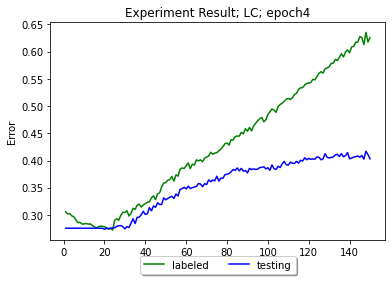

In [5]:
import matplotlib.pyplot as plt

print(expr6._besttestacc)

query_num = range(1,150+1)
plt.plot(query_num, E_out_6['labeled_acc'], 'g', label='labeled')
plt.plot(query_num, E_out_6['testing_acc'], 'b', label='testing')

plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('Experiment Result; LC; epoch4')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=5)
plt.show()

0.41422466422466425


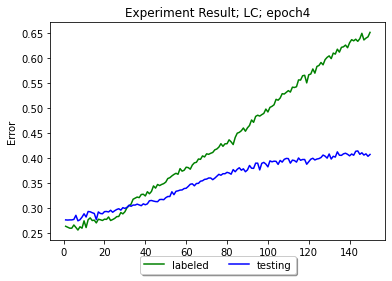

In [68]:
import matplotlib.pyplot as plt

print(expr6._besttestacc)

query_num = range(1,150+1)
plt.plot(query_num, E_out_6['labeled_acc'], 'g', label='labeled')
plt.plot(query_num, E_out_6['testing_acc'], 'b', label='testing')

plt.xlabel('Number of Queries')
plt.ylabel('Error')
plt.title('Experiment Result; LC; epoch4')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=5)
plt.show()

In [6]:
fname = 'cbalTBiome3.txt'
ofile = open(fname, 'wb')
pickle.dump([E_out_6, 'epoch=4; quota=150'], ofile)
ofile.close()